In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import altair as alt

from stimuli import generate_sequence, encode_input, Dataset
from snn_params import Params
from snn_network import SNN

In [2]:
# Initialize parameters
params = Params()
params.config_sim(tmin=0, tmax=0.6, dt=0.005)
print(params.sim["T"][0:10])

[0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045]


### Input sequence

In [3]:
# Create dataset
seq, rsp, out_seq = generate_sequence(n_inner=4, n_outer=300, seed=95)
inp = encode_input(sequence=seq)
print(np.sum(out_seq=="AX"))
print(np.sum(out_seq=="BY"))

239
245


1072


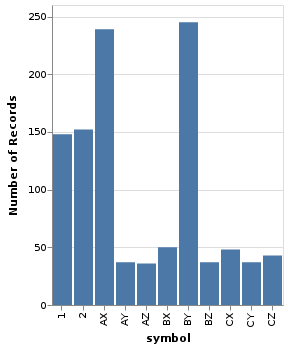

In [4]:
# Create dataframe for viz
df = pd.DataFrame(data=out_seq, columns=["symbol"])
print(len(out_seq))
# contruct a char

alt.Chart(data=df).mark_bar().encode(
    x="symbol",
    y="count()"
).interactive()


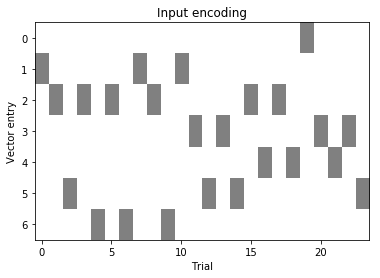

In [10]:
plt.imshow(encoding[0].T, aspect="auto", cmap="gray_r", alpha=0.5)
plt.title("Input encoding")
plt.xlabel("Trial")
plt.ylabel("Vector entry")
plt.show()

Create a Pytorch dataset subclass

In [15]:
dat = Dataset(sequence=sequence, response=response, encoding=encoding, epoch=epoch)

### Network set up

In [16]:
# Set up the network architecture and define parameters
net = SNN()

# Membrane parameters
net.init_neurons(n=1000)  # Number of neurons
net.config_membrane(E=-0.07, V_reset=-0.08, V_thr=-0.05, R=1e6, tau=0.01)  # Membrane parameters

# Synaptic parameters
net.config_syn(tau=0.5, delta_g=10e-9)
net.init_weights(dim=[8, 1000, 2])  # define sizes of weight matrices
net.config_input_weights(mean=0.4, density=0.05)
net.config_recurrent_weights(density=0.1, ex=0.8)

net.weight_scaling(input_scaling=1, recurrent_scaling=1.9e-9)

# Spike-rate adaptation and refractoriness
net.config_gsra(tau=0.4, delta=15e-9, E_r=-0.08)
net.config_gref(tau=0.002, delta=200e-9, E_r=-0.08)

### Connectivity matrices

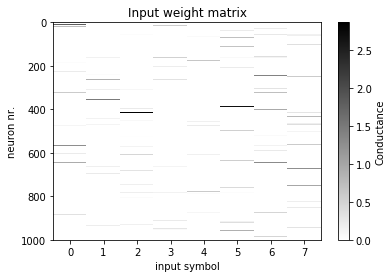

In [17]:
plt.imshow(net.w["input"], aspect="auto", cmap="gray_r")
plt.title("Input weight matrix")
plt.ylabel("neuron nr.")
plt.xlabel("input symbol")
c = plt.colorbar()
c.set_label("Conductance")
plt.show()

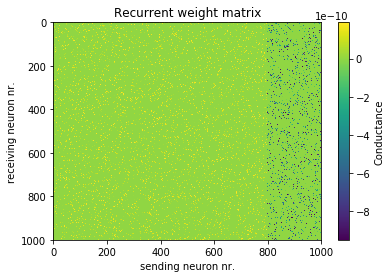

In [18]:
plt.imshow(net.w["recurrent"], aspect="auto")
plt.title("Recurrent weight matrix")
plt.ylabel("receiving neuron nr.")
plt.xlabel("sending neuron nr.")
c2 = plt.colorbar()
c2.set_label("Conductance")
plt.show()

In [21]:
# Configure recording matrices

net.config_recording(dataset=dat, t=params.sim["T"])

# Create step current for input
step_current = params.step_current(t=params.sim["T"],
                                   on=0.30,
                                   off=0.35,
                                   amp=4.4e-9)

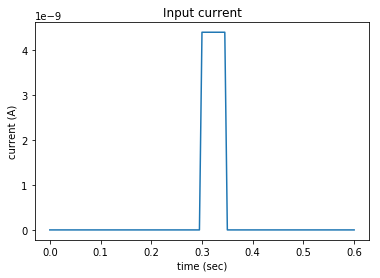

In [20]:
plt.plot(params.sim["T"], step_current)
plt.title("Input current")
plt.xlabel("time (sec)")
plt.ylabel("current (A)")
plt.show()

### Stimulate and record network responses

In [20]:
# Train the network
net.train(dataset=ds, sequence=inp)

Trial nr. 0
Trial nr. 1
Trial nr. 2
Trial nr. 3
Trial nr. 4


### Plot responses

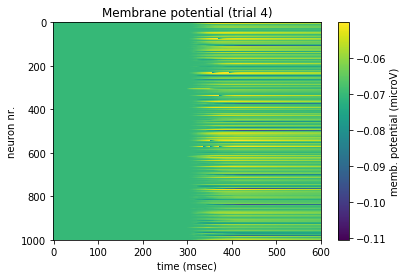

In [34]:
trial = 3
plt.imshow(net.recording["V"][:,:,trial], aspect="auto") # trial nr 1
plt.title("Membrane potential " + "(trial " + str(trial+1) + ")")
plt.xlabel("time (msec)")
plt.ylabel("neuron nr.")
c = plt.colorbar()
c.set_label("memb. potential (microV)")

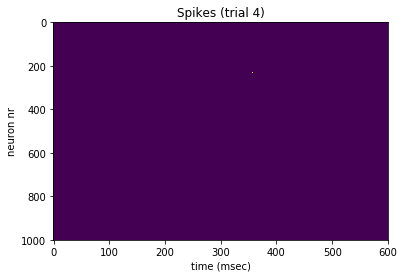

In [35]:
plt.imshow(net.recording["spikes"][:, :, trial], aspect="auto")
plt.title("Spikes " + "(trial " + str(trial+1) + ")")
plt.xlabel("time (msec)")
plt.ylabel("neuron nr")
plt.show()